# Exploração dados COVID-19 em Portugal

In [1]:
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pandas as pd
import numpy as np
import matplotlib
import sys
import os

from IPython.display import Image
from osgeo import ogr

from qgis.core import *

from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

## Continent Analysis

### parse_data_by_continent

This function parses a **csv** and populates a **DataFrame** from **Pandas** in the correct column. For example, gets the number of confirmed in Portugal, and add that number to the current total of confirmed in Europe.

In [2]:
def parse_data_by_continent(df_continent, csv, date, column):
    df = pd.read_csv(csv)
    n_rows = df.shape[0]
    
    for i in range(n_rows):
        country_name = df.at[i, "Country/Region"]
        if "(" in country_name:
            country_name = country_name.split()[0]
        elif "Cote" in country_name:
            country_name = "Côte d'Ivoire"
        elif "Korea" in country_name:
            country_name = "Korea, Republic of"
        elif "Taiwan" in country_name:
            country_name = "Taiwan"
        elif "US" in country_name:
            country_name = "USA"

        try:
            country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)

            if continent_name == "EU":
                index = 0
            elif continent_name == "NA":
                index = 1
            elif continent_name == "SA":
                index = 2
            elif continent_name == "AS":
                index = 3
            elif continent_name == "AF":
                index = 4
            elif continent_name == "OC":
                index = 5

            df_continent.at[index, column] += df.at[i, date]
        except:
            pass

### data_by_continent

This function creates a **DataFrame** from **Pandas** and populates with the number of confirmed, deaths and recovered from each continent.

In [3]:
def data_by_continent(date, confirmed_csv, death_csv, recovered_csv):
    data = {'Continent': ['Europe', 'North America', 'South America', 'Asia', 'Africa', 'Oceania'],
        'Confirmed': [0, 0, 0, 0, 0, 0],
        'Death': [0, 0, 0, 0, 0, 0],
        'Recovered': [0, 0, 0, 0, 0, 0]}

    df_continent = pd.DataFrame(data)
    
    parse_data_by_continent(df_continent, confirmed_csv, date, "Confirmed")
    parse_data_by_continent(df_continent, death_csv, date, "Death")
    parse_data_by_continent(df_continent, recovered_csv, date, "Recovered")

    return df_continent

In [4]:
cssegi_sand_data = "data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_global = cssegi_sand_data + "time_series_covid19_confirmed_global.csv"
death_global = cssegi_sand_data + "time_series_covid19_deaths_global.csv"
recovered_global = cssegi_sand_data + "time_series_covid19_recovered_global.csv"

covid_by_continent = data_by_continent("4/28/20", confirmed_global, death_global, recovered_global)
covid_by_continent.head()

,Continent,Confirmed,Death,Recovered
0,Europe,1324403,126439,459903
1,North America,1097491,63557,149551
2,South America,155415,7587,54178
3,Asia,494287,17905,245954
4,Africa,34794,1523,11328


## Create a bar plot

The following bar plot was created using the values from the table above.

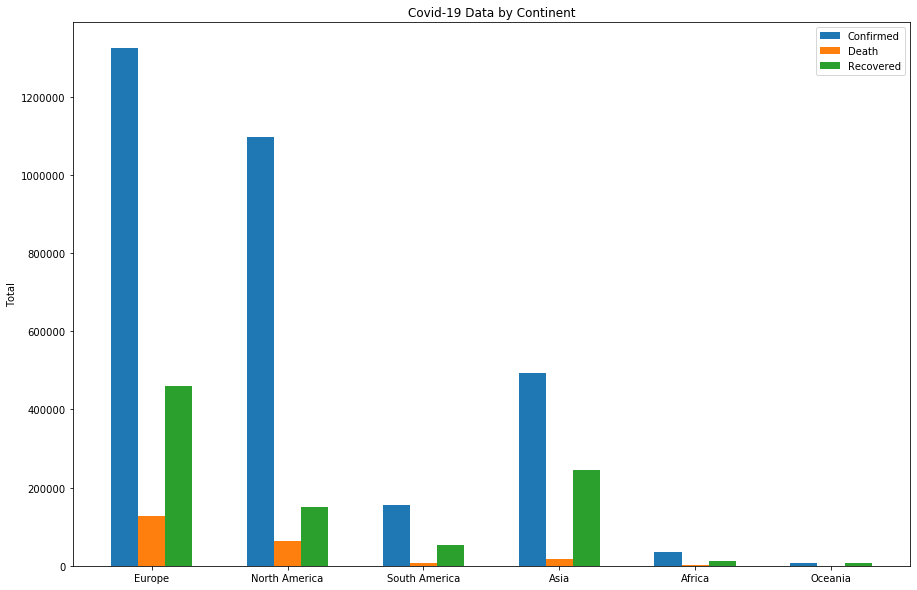

In [5]:
labels = covid_by_continent["Continent"]
confirmed = covid_by_continent["Confirmed"]
death = covid_by_continent["Death"]
recovered = covid_by_continent["Recovered"]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x,           confirmed, width, label='Confirmed', align='center')
ax.bar(x + width,   death,     width, label='Death',     align='center')
ax.bar(x + width*2, recovered, width, label='Recovered', align='center')

ax.set_ylabel('Total')
ax.set_title('Covid-19 Data by Continent')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

## Portugal

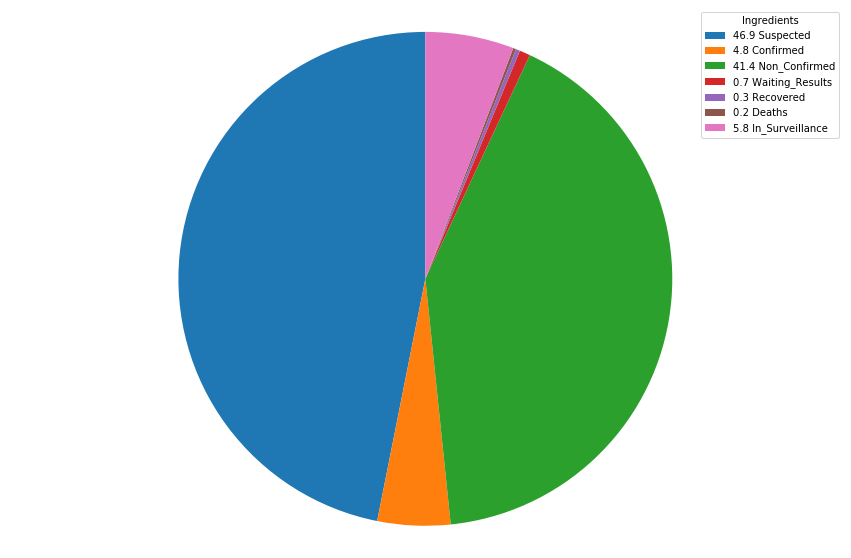

In [6]:
data_pt = pd.read_csv("data\covid-pt\situacao_epidemiologica.csv")

current_row = data_pt.loc[data_pt['data_relatorio'] == "2020-04-28"]

suspected_num = current_row["suspeitos"].iloc[0]
confirmed_num = current_row["confirmados"].iloc[0]
non_confirmed_num = current_row["nao_confirmados"].iloc[0]
waiting_results_num = current_row["aguarda_resultados"].iloc[0]
recovered_num = current_row["recuperados"].iloc[0]
deaths_num = current_row["obitos"].iloc[0]
in_surveillance_num = current_row["em_vigilancia"].iloc[0]

total = suspected_num + confirmed_num + non_confirmed_num + waiting_results_num + recovered_num + deaths_num + in_surveillance_num

suspected_perc = (suspected_num/total)*100
confirmed_perc = (confirmed_num/total)*100
non_confirmed_perc = (non_confirmed_num/total)*100
waiting_results_perc = (waiting_results_num/total)*100
recovered_perc = (recovered_num/total)*100
deaths_perc = (deaths_num/total)*100
in_surveillance_perc = (in_surveillance_num/total)*100

sizes = [suspected_perc, confirmed_perc, non_confirmed_perc, waiting_results_perc, recovered_perc, deaths_perc, in_surveillance_perc]

fig1, ax1 = plt.subplots(figsize=(15,10))
patcheslist, texts = ax1.pie(sizes, startangle=90)
ax1.axis('equal')

labels = "%.1f" % round(suspected_perc, 2) + " Suspected", "%.1f" % round(confirmed_perc, 2) + " Confirmed", "%.1f" % round(non_confirmed_perc, 2) + " Non_Confirmed", "%.1f" % round(waiting_results_perc, 2) + " Waiting_Results", "%.1f" % round(recovered_perc, 2) + " Recovered", "%.1f" % round(deaths_perc, 2) + " Deaths", "%.1f" % round(in_surveillance_perc, 2) + " In_Surveillance"

ax1.legend(patcheslist, labels, title="Ingredients")

plt.show()

## World Map

In this section, a world map is rendered, having the countries filled with a color gradient, that gets more intense with a greater number o confirmed people with **Covid-19**

### Preparing Qgis

In [7]:
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/local/share/qgis/python')
QgsApplication.setPrefixPath("/usr/local", True) 
qgs = QgsApplication([], False)
qgs.initQgis()
#print(QgsApplication.showSettings())

### Loading the world map layer

In [8]:
covid_gpkg = "data/Countries_with_Covid.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))


Layer Countries_with_Covid loaded
Layer layer_styles loaded


### Analysing some data from the layer

In [9]:
concelho = QgsProject.instance().mapLayersByName('Countries_with_Covid')[0]
for c in concelho.getFeatures():
        print("Em {} há {} caso(s) confirmados".format(c["Name"], c["4/28/20_sum"]))

Em Indonesia há 9511.0 caso(s) confirmados
Em Malaysia há 5851.0 caso(s) confirmados
Em Chile há 14365.0 caso(s) confirmados
Em Bolivia há 1014.0 caso(s) confirmados
Em Peru há 31190.0 caso(s) confirmados
Em Argentina há 4127.0 caso(s) confirmados
Em Dhekelia há 0.0 caso(s) confirmados
Em Cyprus há 0.0 caso(s) confirmados
Em India há 31324.0 caso(s) confirmados
Em China há 82858.0 caso(s) confirmados
Em Israel há 15728.0 caso(s) confirmados
Em Palestine há 343.0 caso(s) confirmados
Em Lebanon há 717.0 caso(s) confirmados
Em Ethiopia há 126.0 caso(s) confirmados
Em S. Sudan há 34.0 caso(s) confirmados
Em Somalia há 528.0 caso(s) confirmados
Em Kenya há 374.0 caso(s) confirmados
Em Pakistan há 14612.0 caso(s) confirmados
Em Malawi há 36.0 caso(s) confirmados
Em Tanzania há 299.0 caso(s) confirmados
Em Syria há 43.0 caso(s) confirmados
Em Somaliland há 0.0 caso(s) confirmados
Em France há 168514.0 caso(s) confirmados
Em Suriname há 10.0 caso(s) confirmados
Em Guyana há 74.0 caso(s) confir

### Creating the map

In [10]:
xt = concelho.extent()
# print(xt)
width  = 900
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([concelho])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()


Gerar mapa com 900 por 434


### Render the map

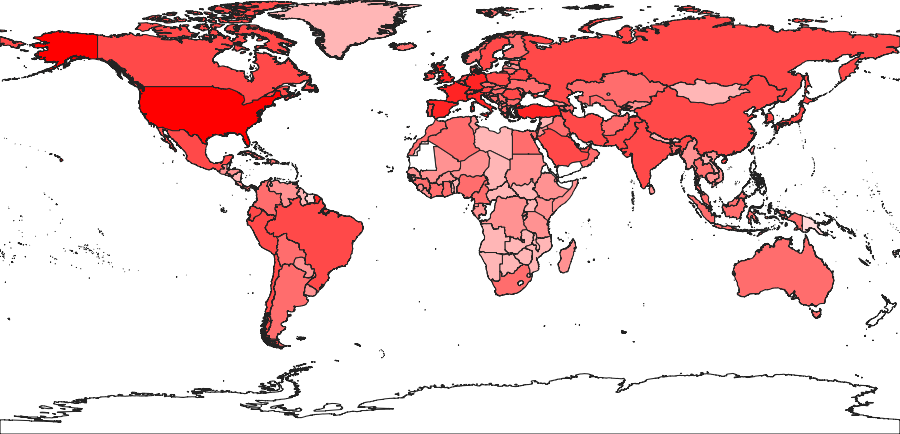

In [11]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

### A gif that shows the progression of Covid-19 
![World_confirmed_upto_15-04-2020](cofirmed-15-04-2020.gif)